In [2]:
import abc # class inheritance
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Example Synthetic Data:

In [3]:
# Example Data
np.random.seed(33)
target = np.random.rand(500)
data = pd.DataFrame.from_dict({'target': target, 'indep': target * 2})
data

,target,indep
0,0.248510,0.497020
1,0.449975,0.899951
2,0.410941,0.821882
3,0.260300,0.520599
4,0.870396,1.740791
...,...,...
495,0.789180,1.578360
496,0.075926,0.151853
497,0.995801,1.991601
498,0.578444,1.156887


## Univariate Linear Regression

In [4]:
class univariate_lr():
    def __init__(self, data, target_var, indep_var, learning_rate=1e-2, limit_iterations = 10000, tol=1e-5, seed=33):
        # Data
        self.data = data
        self.y = data[target_var]
        self.x = data[indep_var]
        
        # pred = m*x + n
        random.seed(seed)
        self.m = random.uniform(-1, 1)
        self.n = random.uniform(-1, 1)

        # Model training
        self.r = learning_rate
        self.limit_iter = limit_iterations
        self.tol = tol

    def __evaluate(self):
        # Prediction
        pred = [(self.m * x + self.n) for x in self.x]

        # L = MSE
        L = np.mean(
            [(yi - (self.m * xi + self.n) )**2 for yi,xi in zip(self.y, self.x)]
        )
        dL_dm = -2 * np.mean(
            [(yi - (self.m * xi + self.n) ) * xi for yi,xi in zip(self.y, self.x)]
        )
        dL_dn = -2 * np.mean(
            [(yi - (self.m * xi + self.n) ) for yi,xi in zip(self.y, self.x)]
        )

        return {
            'pred': pred,
            'L': L,
            'dL_dm': dL_dm,
            'dL_dn': dL_dn
        }

    def __update_coef(self, dL_dm, dL_dn, r):
        self.m -= r*dL_dm
        self.n -= r*dL_dn

    def train(self):
        self.loss = []
        for _ in range(self.limit_iter):
            results_dic = self.__evaluate()
            self.loss.append(results_dic['L'])

            self.__update_coef(dL_dm = results_dic['dL_dm'], 
                            dL_dn = results_dic['dL_dn'],
                            r = self.r)
            if results_dic['L'] < self.tol:
                print(results_dic['L'])
                break
        
        fig = plt.figure()
        plt.scatter(x=self.x, y=self.y)
        plt.scatter(x=self.x, y=results_dic['pred'])
        self.MSE = results_dic['L']

        fig = plt.figure()
        plt.scatter(x=np.arange(stop=len(self.loss)), y=self.loss)
        self.MSE = results_dic['L']
        

In [5]:
model = univariate_lr(data=data, target_var='target', indep_var='indep')
model

9.946001747442602e-06


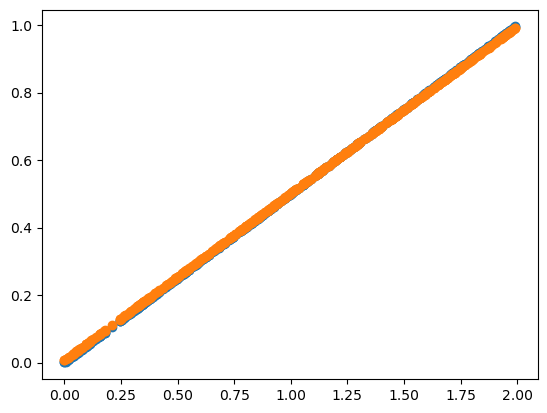

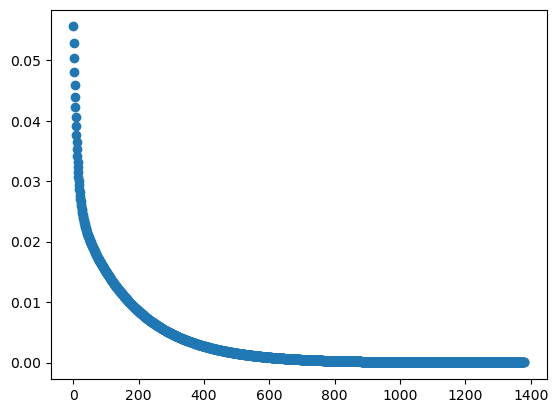

In [6]:
model.train()


## General Regression Model
- Inherit most methods from a base model.
- Applicable to univariate and multivariate linear regression, polynomial regression, logistic regression. (maybe L1 and L2 regression too.)

In [63]:
class base_regression_model(abc.ABC):
    def __init__(self, data: pd.DataFrame, y_name: str, x_names, iter_limit=1000, tolerance=1e-3, learning_rate=1e-3, random_seed=33, plot_results=True):
        # Ensure x_names is a tuple or list
        if type(x_names) == str:
            x_names = (x_names, )
        
        # Data
        self.data = data
        
        # Formula: y = m·x + n * 1.0, where y, m, x and n are vectors 
        self.y = data.loc[:, y_name]
        self.x = data.loc[:, x_names]
        self.x['bias'] = 1.0 
        
        # Prediction and loss values initialization
        self.pred = np.repeat(0.0, repeats=len(self.y))
        self.loss = []

        # Additional parameters to control how training is performed
        self.iter_limit = iter_limit
        self.tol = tolerance
        self.seed = random_seed
        self.lr = learning_rate
        self.plot_results = plot_results


    @abc.abstractmethod
    def _evaluate(self):
        """
        This method must be implemented by child classes.
        Should return a tuple: (loss, gradient_dict)
        """
        pass

    def _update(self, gradient: dict):
        # Update uses "-=" to advance in the direction of decreasing loss
        for col in self.coeff:
            self.coeff[col] -= self.lr * gradient[col]

    def predict(self, X: pd.DataFrame = None):
        '''
        Calculate the dot product of X with the coefficients. If X is not specified, then training data is used.
        '''
        if X is None:
            X = self.x

        return np.dot(
            X,
            np.array([self.coeff[col] for col in X.columns])
        )

    def plot(self):
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

        # Predicted vs actual
        axs[0].scatter(self.pred, self.y, alpha=0.6)
        axs[0].plot(
            [self.y.min(), self.y.max()],
            [self.y.min(), self.y.max()],
            color='red', linestyle='--',
            label = 'Ideal Fit'
        )

        axs[0].set_title('Predicted vs Actual')
        axs[0].set_xlabel('Predicted values')
        axs[0].set_ylabel('Actual Values')
        axs[0].legend()

        # Plot loss curve
        axs[1].scatter(np.arange(stop=len(self.loss)), self.loss, alpha=0.6, s=10)
        axs[1].set_title('Loss Over Iterations')
        axs[1].set_xlabel('Iteration')
        axs[1].set_ylabel('Loss')

        # Plot
        plt.tight_layout()
        plt.show()

    def train(self):
        '''
        Perform gradient descent iteratively to optimize coefficients.
        '''
        # Set random coefficients
        random.seed(self.seed)
        self.coeff = {
            x: random.uniform(-1.0, 1.0) for x in self.x
        }

        # Calculate prediction from random coefficients (starting point)
        self.pred = self.predict()

        for _ in range(self.iter_limit):
            # The loss function and its gradient
            (loss, gradient) = self._evaluate()
            self.loss.append(loss)

            # Check if the loss function is under the tolerated error (stop if true)
            if loss < self.tol:
                break
            
            # Update the coefficients
            self._update(gradient)
        
            # Calculate prediction with updated coefficients
            self.pred = self.predict()
        
        # Plot results
        if self.plot_results:
            self.plot()

    def summary(self):
        '''
        Statistical summary of the model.
        '''
        # Compute statistical measures
        mean_pred = np.mean(self.pred)
        num = np.sum([ (y - pred) ** 2 for (y,pred) in zip(self.y, self.pred)])
        den = np.sum([ (y - mean_pred) ** 2 for y in self.y ])
        r2 = 1 - num/den

        # Show results
        print('Model Summary')
        print('-' * 50)
        print(f'R^2 = {r2}')
        print(f'MSE = {self.loss[-1]}')
        display(pd.DataFrame.from_dict(
            {'Variable': [name for name in self.x],
             'Coefficient': [value for value in self.coeff.values()]}
        ))

    
        



In [64]:
class univariate_lr(base_regression_model):
    def _evaluate(self):
        # Loss function
        errors = self.y - self.pred
        loss = np.mean(errors ** 2)
        
        # Gradient:
        # - For independent variables:  d(loss)/d(m_k) = -2/N sum_(i=1)^(N) [errors_i * self.x_i]
        # - For bias:                   d(loss)/d(m_k) = -2/N sum_(i=1)^(N) [errors_i * 1]
        # 
        # As self.x['bias'] = 1, extending the first expression to all variables, includes the bias.
        gradient = {
            var: (-2 * np.mean(errors * self.x[var])) for var in self.x
        }
        
        # Return loss function and gradients
        return (loss, gradient)

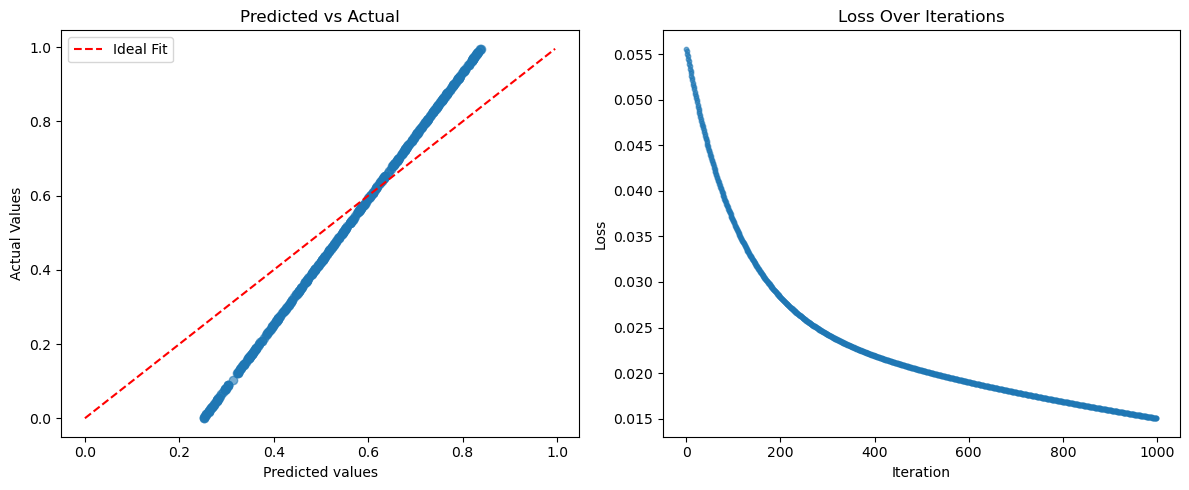

In [65]:
model = univariate_lr(data, y_name='target', x_names='indep')
model.train()

In [46]:
model.summary()

Model Summary
--------------------------------------------------
R^2 = 0.8193477725789511
MSE = 0.015050394436968732


,Variable,Coefficient
0,indep,0.294529
1,bias,0.251230
